In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
import tensorflow as tf
import numpy as np
import cv2
from craft_text_detector import (
    load_craftnet_model,
    load_refinenet_model,
    get_prediction,
    export_detected_regions,
    export_extra_results,
    empty_cuda_cache
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import pytesseract
from PIL import Image

%matplotlib inline

2022-10-30 23:55:56.093694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-30 23:55:56.219626: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-30 23:55:56.656599: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-30 23:55:56.656637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
modelo_yolo = torch.hub.load('Extracion_texto_doc/YoloModel/yolov5/','custom',path='Extracion_texto_doc/YoloModel/mi_modelo/weights/best.pt', source='local') 
modelo_DE = tf.keras.models.load_model('Extracion_texto_doc/DeepEraseModel/my_model')
refine_net = load_refinenet_model()
craft_net = load_craftnet_model()

YOLOv5 🚀 v6.2-183-gc98128f Python-3.8.10 torch-1.12.1+cu102 CPU

Fusing layers... 
YOLOv5x summary: 322 layers, 86193601 parameters, 0 gradients, 203.8 GFLOPs
Adding AutoShape... 
2022-10-30 23:56:01.544697: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-10-30 23:56:01.544719: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: victorcimat
2022-10-30 23:56:01.544723: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: victorcimat
2022-10-30 23:56:01.544776: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2022-10-30 23:56:01.544788: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2022-10-30 23:56:01.544792: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5
2022-10-30 23:56:01.545007: I tensorflow/cor

In [366]:
imagen = "prueba_img/prueba_img_1.jpg"
imagen_r = cv2.cvtColor(cv2.imread(imagen), cv2.COLOR_BGR2GRAY)
cv2.imwrite(imagen,imagen_r)

True

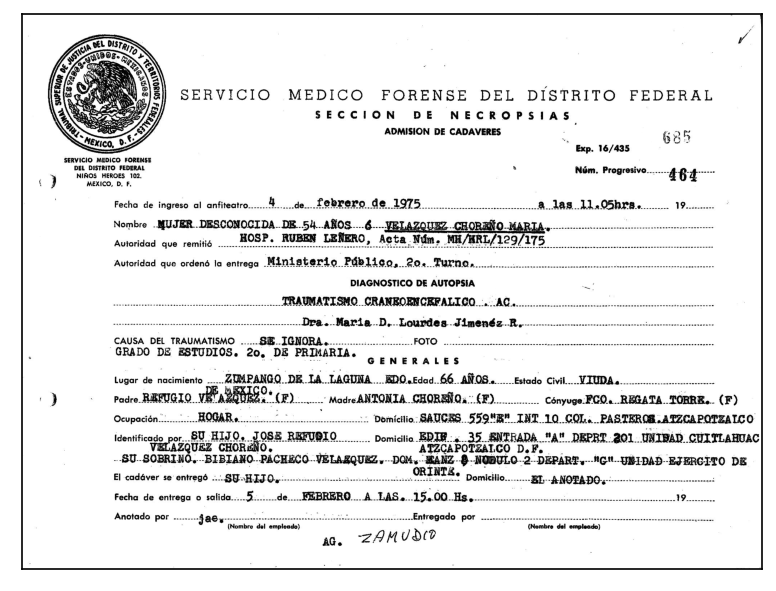

In [367]:
%matplotlib inline

fig = plt.figure(dpi=150)
plt.imshow(imagen_r,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [368]:
documento_marcado = modelo_yolo(imagen, augment=True)

In [369]:
recortes = [imgCrop['im'] 
            for imgCrop in documento_marcado.crop(save=False) 
            if imgCrop['conf'] > 0.7 ]
etiquetas = [imgCrop['label'][:len(imgCrop['label'])-5] 
             for imgCrop in documento_marcado.crop(save=False) 
             if imgCrop['conf'] > 0.7 ]

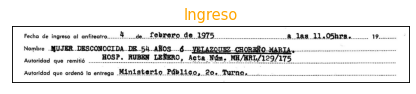

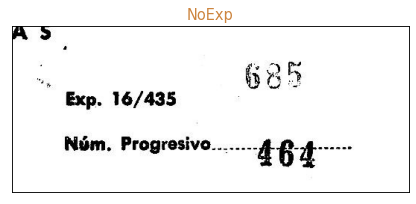

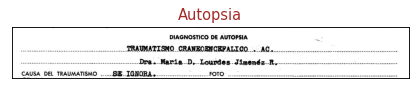

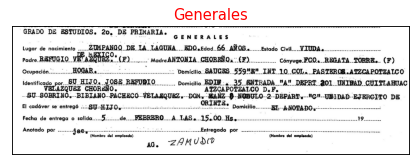

In [370]:
colores = ['orange','peru','brown','red']
for i, imgCrop in enumerate(recortes):
    fig = plt.figure( dpi=80)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgCrop,cmap='gray')
    plt.title(etiquetas[i],color=colores[i])
    plt.show()

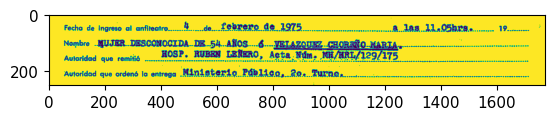

In [371]:
plt.imshow(cv2.cvtColor(recortes[0], cv2.COLOR_BGR2GRAY)>220)

In [455]:
recortes_bi = []
for rec in recortes:
    bw = cv2.cvtColor(rec, cv2.COLOR_BGR2GRAY)
    recortes_bi.append(255-bw)

idRec = 3

if etiquetas[idRec] == 'NoExp':
    prediction_result = get_prediction(
        image=recortes_bi[idRec],
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.1,
        link_threshold=0.4,
        low_text=0.01,
        cuda=False,
        long_size=1000
    )
else:
    prediction_result = get_prediction(
        image=recortes_bi[idRec],
        craft_net=craft_net,
        refine_net=refine_net,
        text_threshold=0.2,
        link_threshold=0.9,
        low_text=0.2,
        cuda=False,
        long_size=5500
    )
recortes_dir = 'output/image_crops/'
!rm -r $recortes_dir
palabras = export_detected_regions(
    image=recortes_bi[idRec],
    regions=prediction_result["boxes"])
for img in palabras:
    imagen = 255-cv2.imread(img,0)
    imagen = np.where(imagen>(np.median(imagen)-0.9*np.std(imagen)), 255, 0)
    cv2.imwrite(img,imagen)

In [470]:
not (''=='')

False

In [456]:
puntos = prediction_result['boxes'][:,0]
palabras_inc = palabras.copy()
p=0
for i, ImPaRePath in enumerate(palabras):
    imagen = cv2.imread(ImPaRePath,0)
    if imagen.shape[1]>256 or imagen.shape[0]>64:
        
        if imagen.shape[0] <= 64:
            LongSize = 500
        else:
            LongSize = 2500
        
        
        imagen[imagen==0]=10
        sub_prediction_result = get_prediction(
            image=imagen,
            craft_net=craft_net,
            refine_net=refine_net,
            text_threshold=0.2,
            link_threshold=0.9,
            low_text=0.2,
            cuda=False,
            long_size= LongSize
        )
        
        recortes_dir2 = 'output/image_crops2/'
        !rm -r $recortes_dir2

        palabras2 = export_detected_regions(
            image = imagen,
            regions = sub_prediction_result["boxes"],
            output_dir = recortes_dir2)
        
        for img in palabras2:
            imagen2 = cv2.imread(img,0)
            imagen2[imagen2==0]=255
            imagen2[imagen2==10]=0
            cv2.imwrite(img,imagen2)
        
        if len(palabras2) != 0:
            cc = ImPaRePath.replace('output/image_crops/','').replace('.png','')+'_'
            incremento  = puntos[i+p]
            puntos = np.delete(puntos,i+p,axis=0)
            palabras_inc.pop(i+p)
            for k, img in enumerate(palabras2):
                imagen = cv2.imread(img,0)
                aa = img.replace('crop_',cc)

                cv2.imwrite(aa,imagen)
                !rm $img
                ll = 'output/image_crops/'
                !mv $aa $ll
                puntos = np.insert(puntos, i+p+k, sub_prediction_result["boxes"][:,0][k]+incremento, axis=0)

                palabras_inc.insert(i+p+k,ll+aa.replace('output/image_crops2/image_crops/',''))

            p+=k
            
            !rm $ImPaRePath
        

In [457]:
palabras_inc = [palabras_inc[i] for i in puntos[:,0].argsort()]
puntos = puntos[puntos[:,0].argsort()]

In [458]:
dimens = (np.min(prediction_result['boxes'][:,0,1]),np.max(prediction_result['boxes'][:,3,1]))

In [459]:
row_amp = np.median(prediction_result['boxes'][:,2,1]-prediction_result['boxes'][:,0,1])
row_amp_std = np.std(prediction_result['boxes'][:,2,1]-prediction_result['boxes'][:,0,1])

In [460]:
if etiquetas[idRec] == 'NoExp':
    rangos = np.arange(dimens[0],dimens[1]-dimens[0],row_amp+row_amp_std)
elif etiquetas[idRec] == 'Ingreso':
    rangos = np.arange(dimens[0],dimens[1]-dimens[0],row_amp+row_amp_std)
elif etiquetas[idRec] == 'Autopsia':
    rangos = np.arange(dimens[0],dimens[1]-dimens[0],row_amp+row_amp_std)
else:
    rangos = np.arange(dimens[0],dimens[1]-dimens[0],row_amp+0.5*row_amp_std)

In [461]:
orden = []
for i in range(len(rangos)-1):
    pintos_in = []
    row_id = []
    for j, p in enumerate(puntos[:,1]):
        if rangos[i]<= p and p < rangos[i+1]:
            pintos_in.append(puntos[:,0][j])
            row_id.append(j)
    pintos_in = np.argsort(np.array(pintos_in))
    orden = orden +  [row_id[k] for k in pintos_in]
orden = np.array(orden)

In [462]:
palab_orde = [palabras_inc[i] for i in orden]

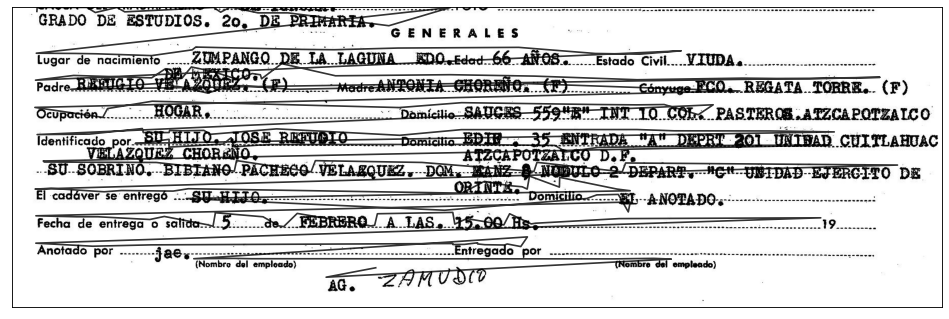

In [463]:
fig = plt.figure(figsize=(15, 10), dpi=80)
plt.imshow(recortes[3],cmap='gray')
plt.plot(puntos[:,0][orden],
         puntos[:,1][orden],'k-',alpha=0.8)
plt.xticks([])
plt.yticks([])
plt.show()

1/1 [==============================] - 0s 20ms/step


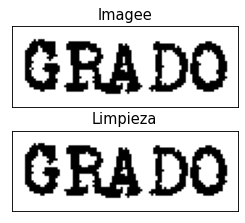


Original:  GRADO
 
 DeepEraser:  GRADO
 

1/1 [==============================] - 0s 19ms/step


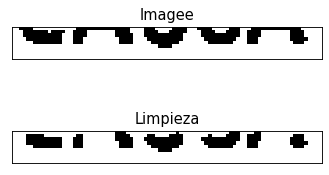


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


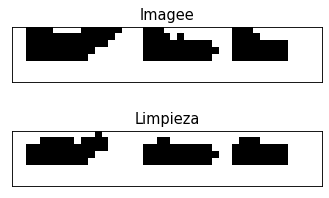


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


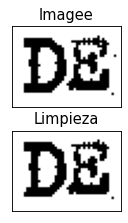


Original:  DE
 
 DeepEraser:  DE
 

1/1 [==============================] - 0s 18ms/step


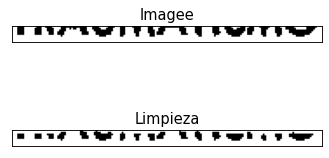


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


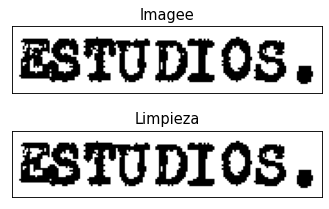


Original:  ESTUDIOS.
 
 DeepEraser:  ESTUDIOS.
 

1/1 [==============================] - 0s 18ms/step


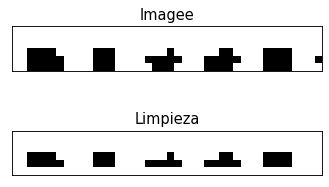


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


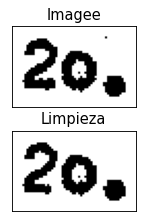


Original:  20,
 
 DeepEraser:  20,
 

1/1 [==============================] - 0s 19ms/step


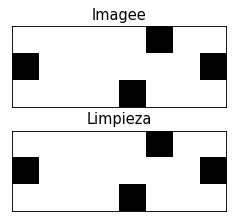


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


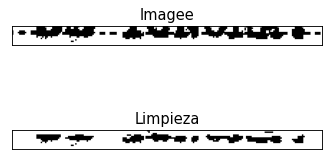


Original:  A  — e O lid Y
 
 DeepEraser:  0 AA ARA
 

1/1 [==============================] - 0s 18ms/step


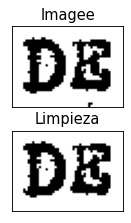


Original:  DE
 
 DeepEraser:  DE
 

1/1 [==============================] - 0s 19ms/step


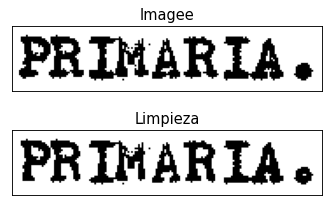


Original:  PRIMARIA.
 
 DeepEraser:  PRIMARIA.
 

1/1 [==============================] - 0s 20ms/step


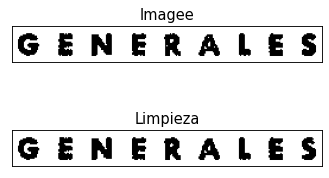


Original:  GENERALES
 
 DeepEraser:  GENERALES
 

1/1 [==============================] - 0s 20ms/step


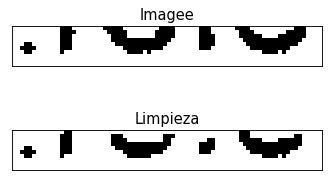


Original:  . E "WwP » Mur
 
 DeepEraser:  . | "wr » ar
 

1/1 [==============================] - 0s 19ms/step


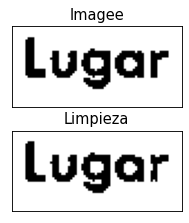


Original:  Lugar
 
 DeepEraser:  Lugar
 

1/1 [==============================] - 0s 19ms/step


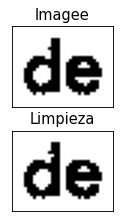


Original:  de
 
 DeepEraser:  de
 

1/1 [==============================] - 0s 19ms/step


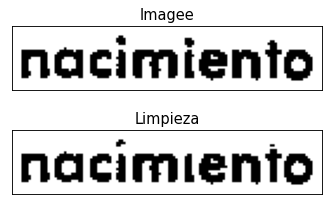


Original:  nacimiento
 
 DeepEraser:  nacimiento
 

1/1 [==============================] - 0s 19ms/step


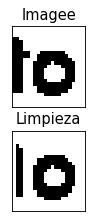


Original:  to
 
 DeepEraser:  lo
 

1/1 [==============================] - 0s 19ms/step


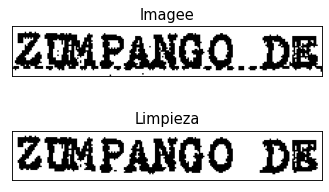


Original:  ZIMPANGO. DE
 
 DeepEraser:  ZUMPANGO DE
 

1/1 [==============================] - 0s 21ms/step


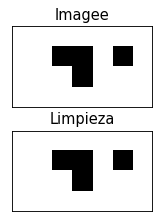


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


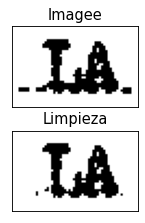


Original:  LA.
 
 DeepEraser:  LA
 

1/1 [==============================] - 0s 19ms/step


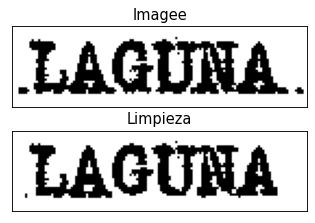


Original:  HAGUNA..
 
 DeepEraser:  LAGUNA
 

1/1 [==============================] - 0s 19ms/step


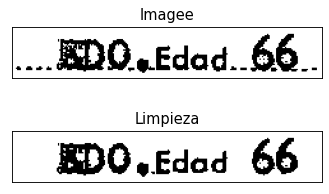


Original:  ... EDO «Edad. 56.
 
 DeepEraser:  EDO .Edad 66
 

1/1 [==============================] - 0s 20ms/step


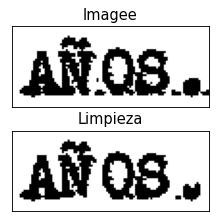


Original:  AÑOS...
 
 DeepEraser:  AÑOS.
 

1/1 [==============================] - 0s 19ms/step


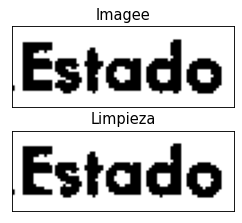


Original:  Estado
 
 DeepEraser:  Estado
 

1/1 [==============================] - 0s 19ms/step


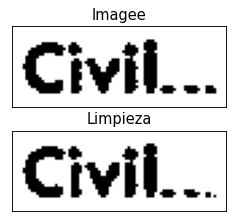


Original:  Civil...
 
 DeepEraser:  Civil...
 

1/1 [==============================] - 0s 22ms/step


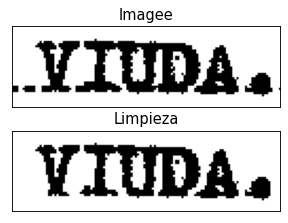


Original:  VIUDA.
 
 DeepEraser:  VIUDA.
 

1/1 [==============================] - 0s 19ms/step


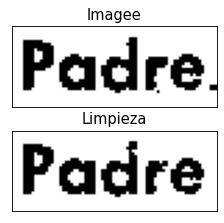


Original:  Padre.
 
 DeepEraser:  Padre
 

1/1 [==============================] - 0s 18ms/step


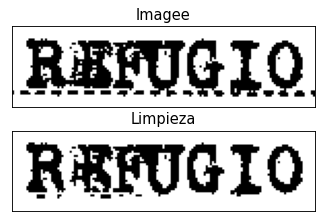


Original:  REFUGIO
 
 DeepEraser:  REFUGIO
 

1/1 [==============================] - 0s 19ms/step


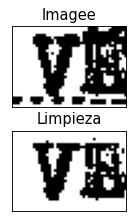


Original:  YE
 
 DeepEraser:  VE
 

1/1 [==============================] - 0s 18ms/step


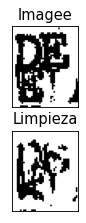


Original:  BE
 
 DeepEraser:  Bs
 

1/1 [==============================] - 0s 19ms/step


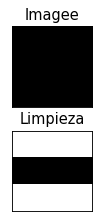


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


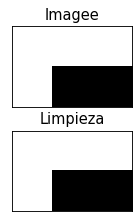


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


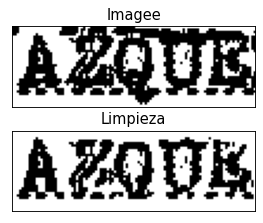


Original:  AGQUE
 
 DeepEraser:  AZOQUE
 

1/1 [==============================] - 0s 18ms/step


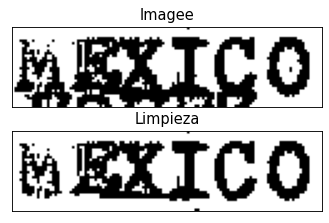


Original:  MEXTCO
 
 DeepEraser:  MEXICO
 

1/1 [==============================] - 0s 18ms/step


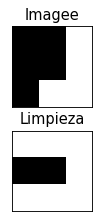


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


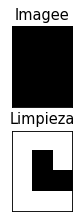


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


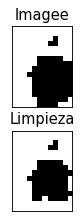


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


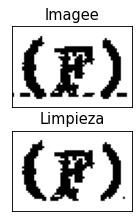


Original:  (6:))
 
 DeepEraser:  (7)
 

1/1 [==============================] - 0s 19ms/step


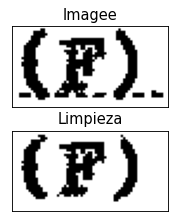


Original:  tE).
 
 DeepEraser:  (FP)
 

1/1 [==============================] - 0s 21ms/step


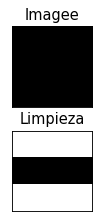


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


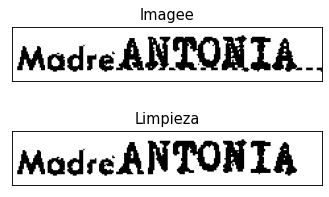


Original:  Madre ANTONIA ..
 
 DeepEraser:  Madre ANTONTA
 

1/1 [==============================] - 0s 18ms/step


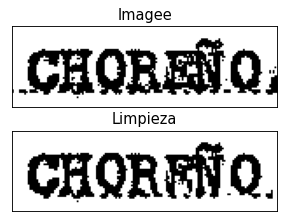


Original:  CHOREÑO,
 
 DeepEraser:  CHOREÑO.
 

1/1 [==============================] - 0s 18ms/step


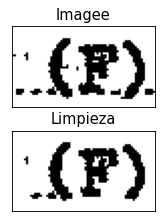


Original:  E).
 
 DeepEraser:  AP)
 

1/1 [==============================] - 0s 20ms/step


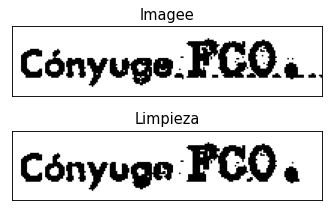


Original:  Cónyuge:FCO 4.
 
 DeepEraser:  Cónyuge FCO.
 

1/1 [==============================] - 0s 18ms/step


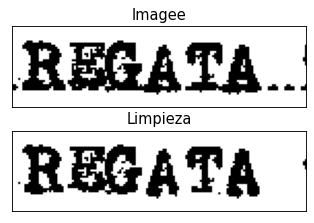


Original:  REGATA..
 
 DeepEraser:  REGATA
 

1/1 [==============================] - 0s 18ms/step


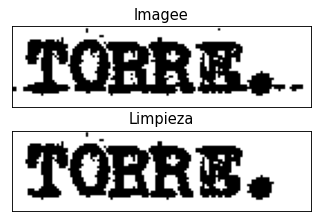


Original:  TORRE...
 
 DeepEraser:  TORRE.
 

1/1 [==============================] - 0s 18ms/step


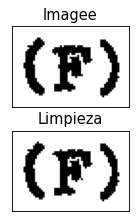


Original:  (7)
 
 DeepEraser:  (m)
 

1/1 [==============================] - 0s 18ms/step


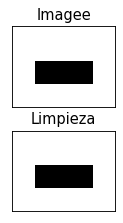


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


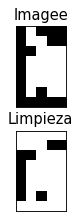


Original:  Ñ
 
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


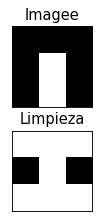


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


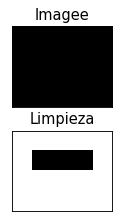


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


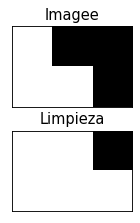


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


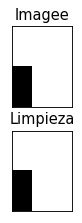


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


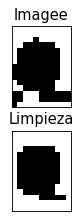


Original:  2
 
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


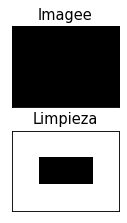


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


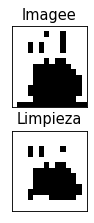


Original:  Pr.
 
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


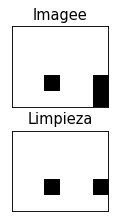


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


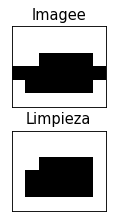


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


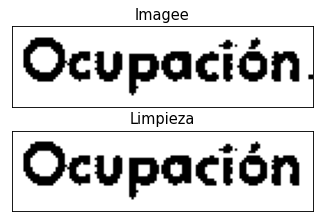


Original:  Ocupación.
 
 DeepEraser:  Ocupación
 

1/1 [==============================] - 0s 19ms/step


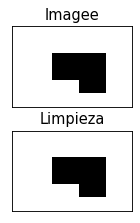


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


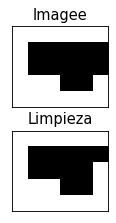


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


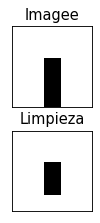


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


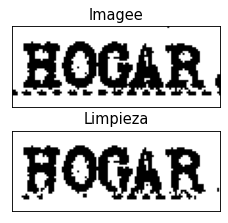


Original:   
 DeepEraser:  HOGAR
 

1/1 [==============================] - 0s 18ms/step


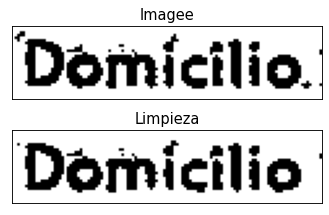


Original:  Domicilio.
 
 DeepEraser:  Domicilio
 

1/1 [==============================] - 0s 18ms/step


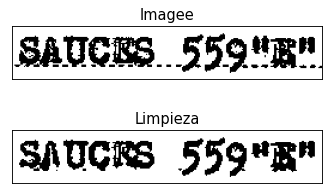


Original:  SATEES. 55988"
 
 DeepEraser:  SAUCES 559 "8"
 

1/1 [==============================] - 0s 17ms/step


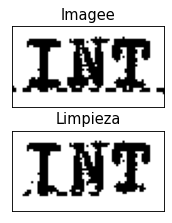


Original:  TNT.
 
 DeepEraser:  TNT
 

1/1 [==============================] - 0s 19ms/step


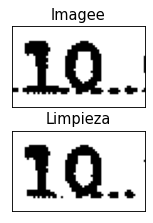


Original:  0.
 
 DeepEraser:  10.
 

1/1 [==============================] - 0s 19ms/step


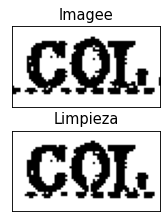


Original:  COL
 
 DeepEraser:  COL
 

1/1 [==============================] - 0s 17ms/step


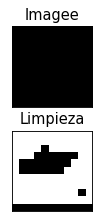


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


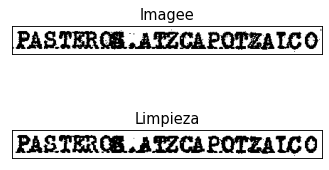


Original:  PASTEROS.ATZCAPOTZATCO
 
 DeepEraser:  PASTEROB.ATZCAPOTZATCO
 

1/1 [==============================] - 0s 20ms/step


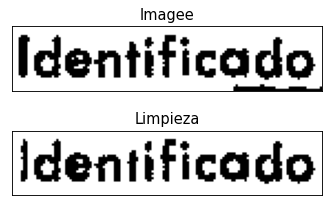


Original:  Identificado
 
 DeepEraser:  Identificado
 

1/1 [==============================] - 0s 20ms/step


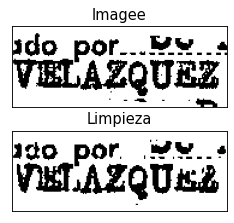


Original:  ido por__.Mw.s
VELAZQUEZ
 
 DeepEraser:  130 por ws
VELAZQUEZ
 

1/1 [==============================] - 0s 17ms/step


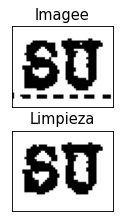


Original:  sy
 
 DeepEraser:  su
 

1/1 [==============================] - 0s 18ms/step


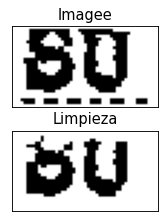


Original:  DU
 
 DeepEraser:  su
 

1/1 [==============================] - 0s 18ms/step


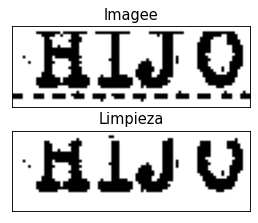


Original:  HIJO
 
 DeepEraser:  HiJO
 

1/1 [==============================] - 0s 19ms/step


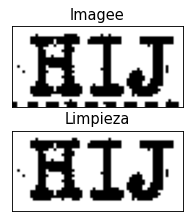


Original:  -HIJ
 
 DeepEraser:  EIJ
 

1/1 [==============================] - 0s 18ms/step


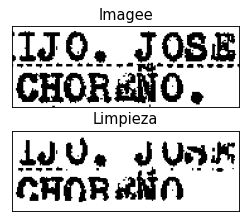


Original:  139. JOSE
CHOREÑO .
 
 DeepEraser:  dd De y Uri
CANREÑO
 

1/1 [==============================] - 0s 19ms/step


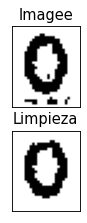


Original:  0
 
 DeepEraser:  0
 

1/1 [==============================] - 0s 19ms/step


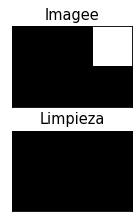


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


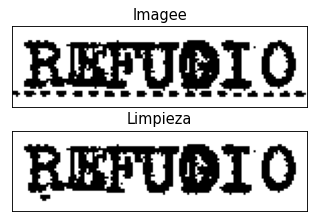


Original:   
 DeepEraser:  REFUBIO
 

1/1 [==============================] - 0s 26ms/step


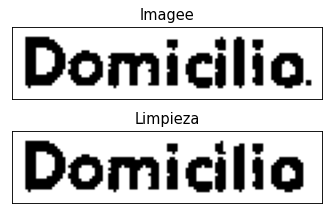


Original:  Domicilio.
 
 DeepEraser:  Domicilio
 

1/1 [==============================] - 0s 19ms/step


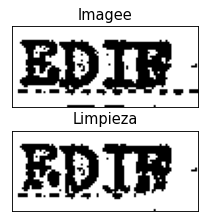


Original:  EDIF .
 
 DeepEraser:  EPTP
 

1/1 [==============================] - 0s 19ms/step


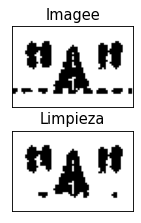


Original:  "
gn
 
 DeepEraser:  "
yn
 

1/1 [==============================] - 0s 19ms/step


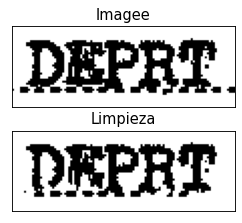


Original:  DEPRT.
 
 DeepEraser:  DEPRT
 

1/1 [==============================] - 0s 19ms/step


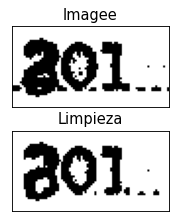


Original:  201.
 
 DeepEraser:  301.
 

1/1 [==============================] - 0s 19ms/step


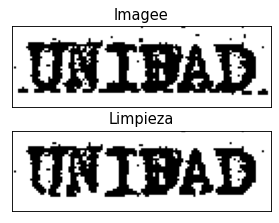


Original:   
 DeepEraser:  UNIDAD
 

1/1 [==============================] - 0s 19ms/step


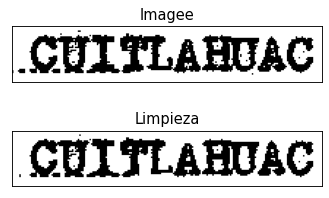


Original:  -CSULILAHUAC
 
 DeepEraser:  CUITLABUAC
 

1/1 [==============================] - 0s 21ms/step


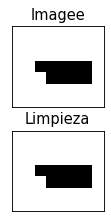


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


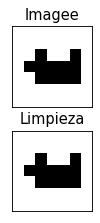


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


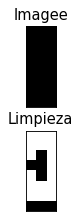


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


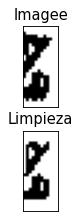


Original:  »
 
 DeepEraser:  Z
 

1/1 [==============================] - 0s 18ms/step


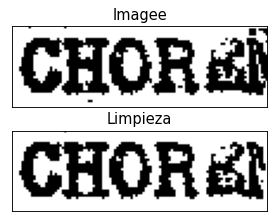


Original:  CHORé
 
 DeepEraser:  CHORé
 

1/1 [==============================] - 0s 19ms/step


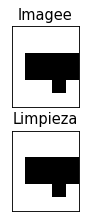


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


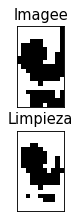


Original:  L
4
 
 DeepEraser:  e
 

1/1 [==============================] - 0s 19ms/step


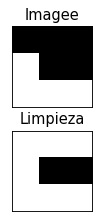


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


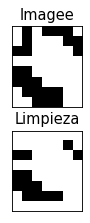


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


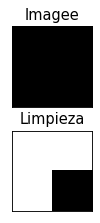


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


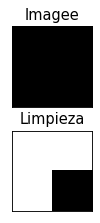


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


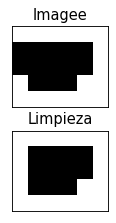


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


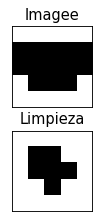


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 21ms/step


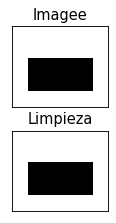


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


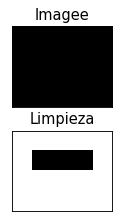


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


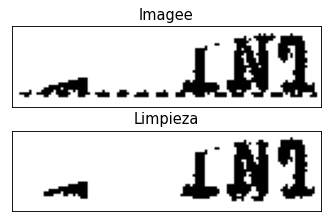


Original:  ANA
 
 DeepEraser:  > 1N2
 

1/1 [==============================] - 0s 19ms/step


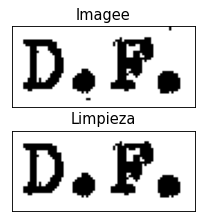


Original:  D.F.
 
 DeepEraser:  D.P.
 

1/1 [==============================] - 0s 20ms/step


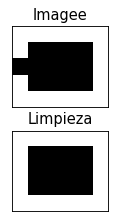


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


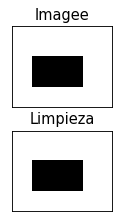


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


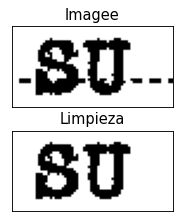


Original:  80...
 
 DeepEraser:  8U
 

1/1 [==============================] - 0s 18ms/step


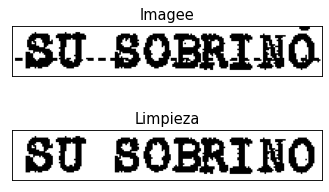


Original:  -80--SOBRINO
 
 DeepEraser:  SU SOBRINO
 

1/1 [==============================] - 0s 20ms/step


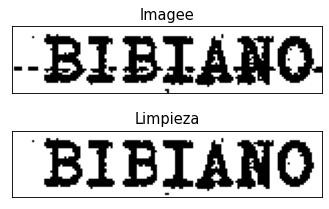


Original:  --BIBIANO.
 
 DeepEraser:  BIBIANO
 

1/1 [==============================] - 0s 19ms/step


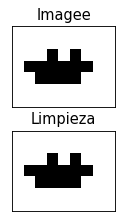


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


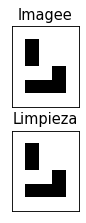


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


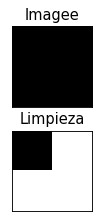


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


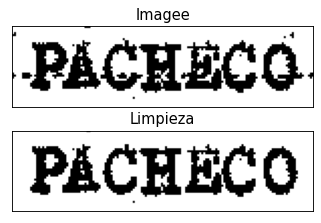


Original:  PACHECO.
 
 DeepEraser:  PACHECO
 

1/1 [==============================] - 0s 19ms/step


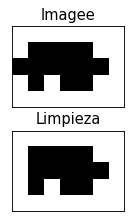


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


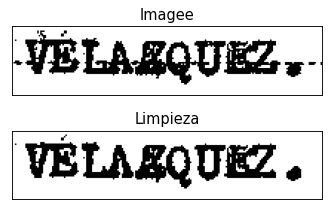


Original:  VELALQUEZ »-
 
 DeepEraser:  VELABQUEZ .
 

1/1 [==============================] - 0s 21ms/step


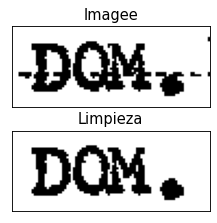


Original:  DOM+-
 
 DeepEraser:  DOM.
 

1/1 [==============================] - 0s 18ms/step


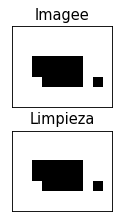


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


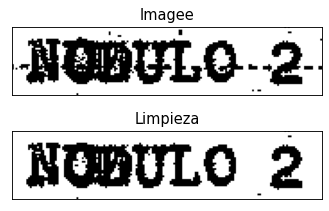


Original:  -NOUBULO-2-
 
 DeepEraser:  NOBULO 2
 

1/1 [==============================] - 0s 18ms/step


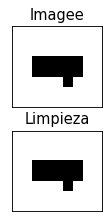


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


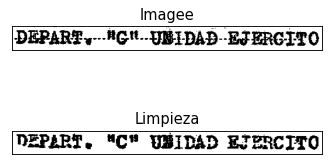


Original:  DEPARE + HG"-OBIDAD-EJERCITO
 
 DeepEraser:  DEPAPT. "C" UBIDAD EJERCITO
 

1/1 [==============================] - 0s 18ms/step


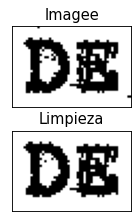


Original:  DE
 
 DeepEraser:  DE
 

1/1 [==============================] - 0s 18ms/step


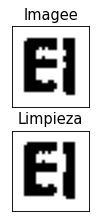


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 22ms/step


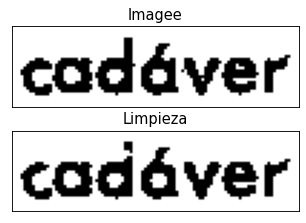


Original:  cadáver
 
 DeepEraser:  cadáver
 

1/1 [==============================] - 0s 18ms/step


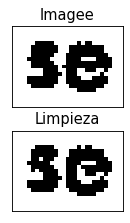


Original:  se
 
 DeepEraser:  se
 

1/1 [==============================] - 0s 17ms/step


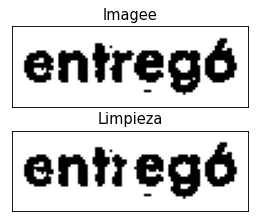


Original:  entregó
 
 DeepEraser:  enhegó
 

1/1 [==============================] - 0s 18ms/step


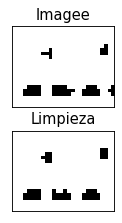


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


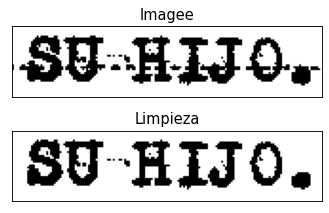


Original:  SU-HIJO,
 
 DeepEraser:  SU-HIJO.
 

1/1 [==============================] - 0s 19ms/step


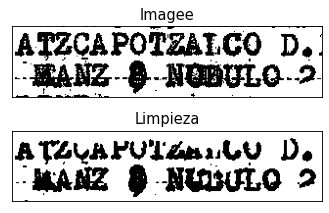


Original:  ATZCAPOTZALCO De
—HANZ--6-NOBULO-2
 
 DeepEraser:  ATZLYAPUTGB LU De
MABZ $ NUBULO 2
 

1/1 [==============================] - 0s 18ms/step


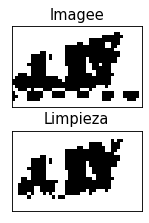


Original:   
 DeepEraser:  74
 

1/1 [==============================] - 0s 18ms/step


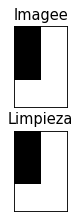


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


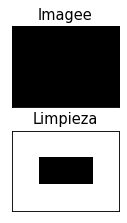


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


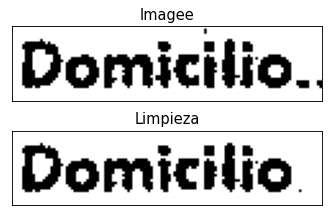


Original:  Domicilio.
 
 DeepEraser:  Domicilio
 

1/1 [==============================] - 0s 18ms/step


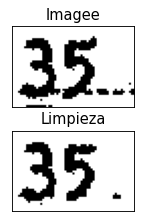


Original:  EL
 
 DeepEraser:  35.
 

1/1 [==============================] - 0s 18ms/step


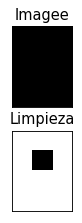


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


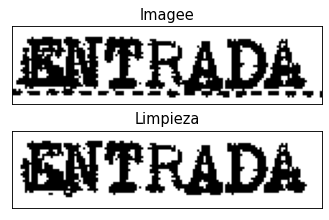


Original:  ENTRADA
 
 DeepEraser:  ENTRADA
 

1/1 [==============================] - 0s 19ms/step


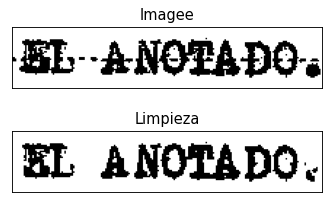


Original:  BE-ANOTPADOS
 
 DeepEraser:  EL ANOTADO.
 

1/1 [==============================] - 0s 17ms/step


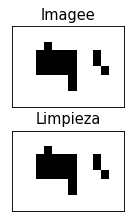


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


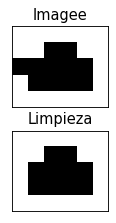


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 23ms/step


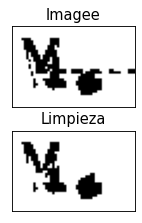


Original:  Ms
 
 DeepEraser:  Me
 

1/1 [==============================] - 0s 17ms/step


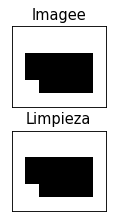


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


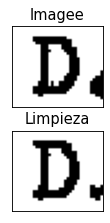


Original:  D.
 
 DeepEraser:  D.
 

1/1 [==============================] - 0s 21ms/step


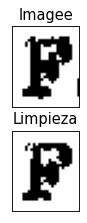


Original:  F
 
 DeepEraser:  P
 

1/1 [==============================] - 0s 18ms/step


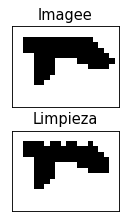


Original:  y»
 
 DeepEraser:  ye
 

1/1 [==============================] - 0s 19ms/step


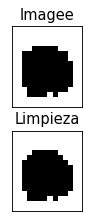


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


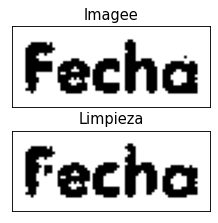


Original:  Fecha
 
 DeepEraser:  Fecha
 

1/1 [==============================] - 0s 18ms/step


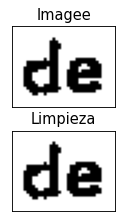


Original:  de
 
 DeepEraser:  de
 

1/1 [==============================] - 0s 19ms/step


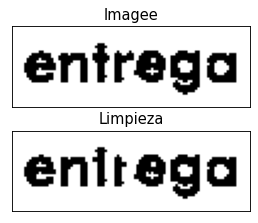


Original:  entrega
 
 DeepEraser:  entrega
 

1/1 [==============================] - 0s 18ms/step


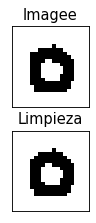


Original:  o
 
 DeepEraser:  o
 

1/1 [==============================] - 0s 19ms/step


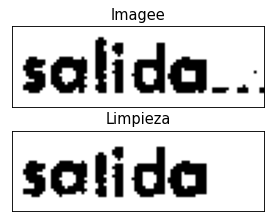


Original:  salida...
 
 DeepEraser:  satida
 

1/1 [==============================] - 0s 19ms/step


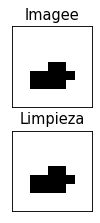


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


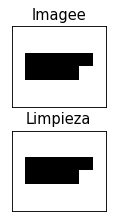


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 21ms/step


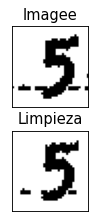


Original:  5
 
 DeepEraser:  5
 

1/1 [==============================] - 0s 20ms/step


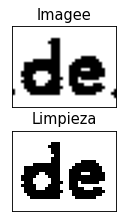


Original:  de
 
 DeepEraser:  de
 

1/1 [==============================] - 0s 19ms/step


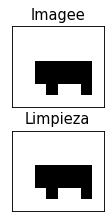


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


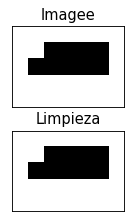


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


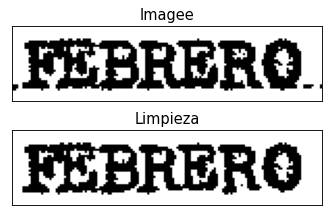


Original:  FEBRERO.
 
 DeepEraser:  FEBRERO
 

1/1 [==============================] - 0s 19ms/step


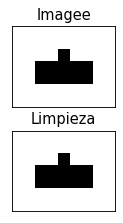


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


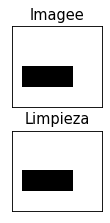


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


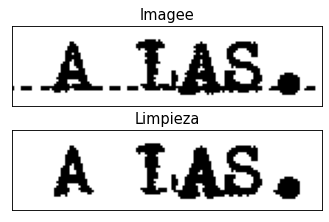


Original:  A TAS.
 
 DeepEraser:  A LAS.
 

1/1 [==============================] - 0s 19ms/step


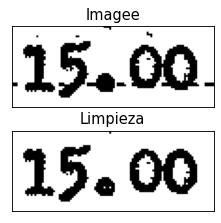


Original:  15.00.
 
 DeepEraser:  15.00
 

1/1 [==============================] - 0s 19ms/step


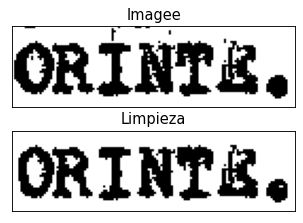


Original:  ORINTE,
 
 DeepEraser:  ORINTE.
 

1/1 [==============================] - 0s 18ms/step


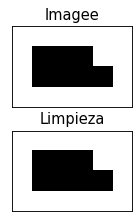


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


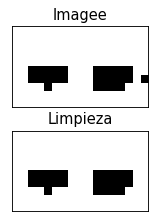


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


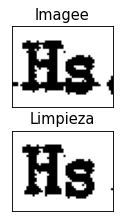


Original:  Hs.
 
 DeepEraser:  Hs
 

1/1 [==============================] - 0s 19ms/step


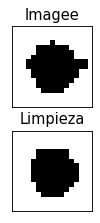


Original:  +
 
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


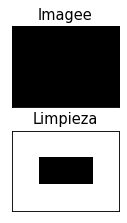


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 20ms/step


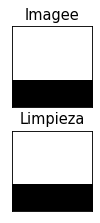


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 21ms/step


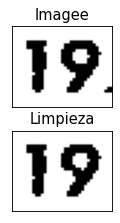


Original:  9.
 
 DeepEraser:  1
 

1/1 [==============================] - 0s 19ms/step


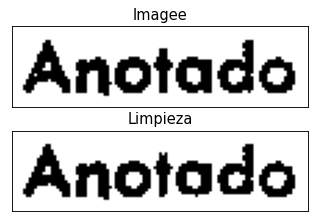


Original:  Anotado
 
 DeepEraser:  Anotado
 

1/1 [==============================] - 0s 20ms/step


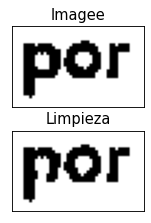


Original:  por
 
 DeepEraser:  por
 

1/1 [==============================] - 0s 20ms/step


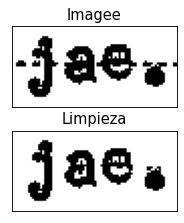


Original:  $aes
 
 DeepEraser:  jas,
 

1/1 [==============================] - 0s 20ms/step


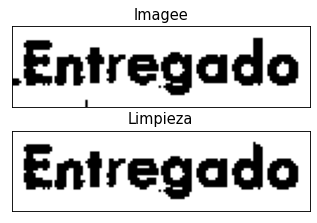


Original:  Entregado
 
 DeepEraser:  Entregado
 

1/1 [==============================] - 0s 20ms/step


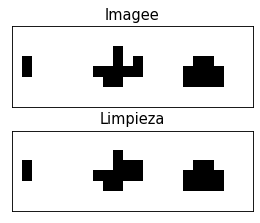


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 22ms/step


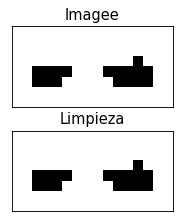


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 23ms/step


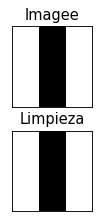


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


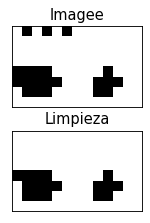


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


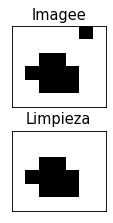


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


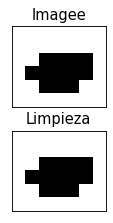


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 18ms/step


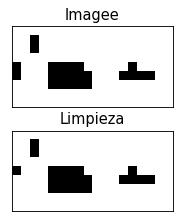


Original:   
 DeepEraser:   

1/1 [==============================] - 0s 19ms/step


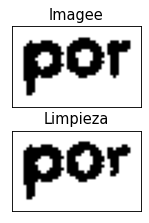


Original:  por
 
 DeepEraser:  por
 

1/1 [==============================] - 0s 21ms/step


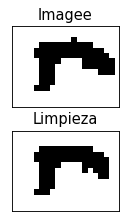


Original:  ye
 
 DeepEraser:  ha
 

1/1 [==============================] - 0s 25ms/step


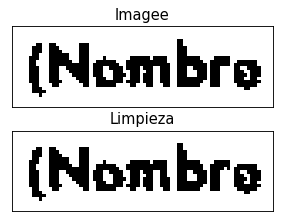


Original:  (Nombre
 
 DeepEraser:  (Nombre
 

1/1 [==============================] - 0s 19ms/step


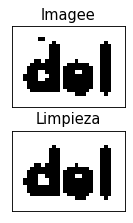


Original:  del
 
 DeepEraser:  del
 

1/1 [==============================] - 0s 19ms/step


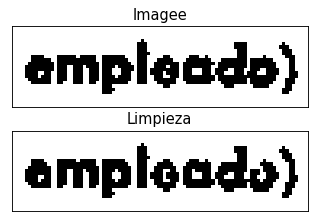


Original:  empleado)
 
 DeepEraser:  emploado)
 

1/1 [==============================] - 0s 20ms/step


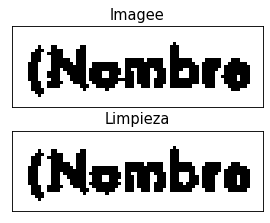


Original:  (Nombre
 
 DeepEraser:  (Nembro
 

1/1 [==============================] - 0s 20ms/step


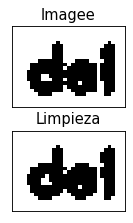


Original:  dal
 
 DeepEraser:  del
 

1/1 [==============================] - 0s 19ms/step


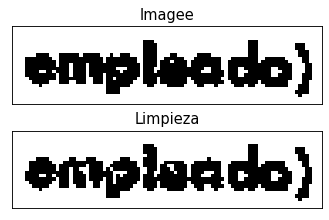


Original:  empleado)
 
 DeepEraser:  empleado)
 

1/1 [==============================] - 0s 19ms/step


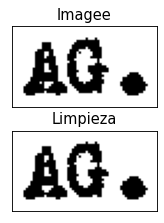


Original:  AGeo
 
 DeepEraser:  AG.
 

1/1 [==============================] - 0s 22ms/step


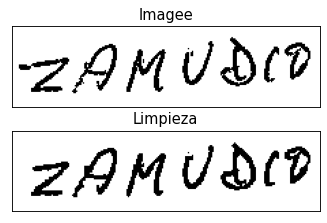


Original:  ZAMUDIO
 
 DeepEraser:  zZAMUDID
 



In [464]:
texto_extraccion = []
for ImPaRePath in palab_orde:
    imagen = cv2.imread(ImPaRePath,0)
    
    imgPalRec = tf.io.read_file(ImPaRePath)
    imgPalRec = tf.image.decode_jpeg(imgPalRec, channels=1)
    imgPalRec = tf.image.resize(imgPalRec, (64,256))
    imgPalRec = tf.image.convert_image_dtype(imgPalRec, tf.float32) / 255.
    imgPalRec = tf.data.Dataset.from_tensors(imgPalRec[None,:,:,:])
    imgPalRecPre = modelo_DE.predict(imgPalRec)
    img_pred =  cv2.resize(imgPalRecPre[0][:,:,0],
                           (imagen.shape[1],imagen.shape[0]),
                           interpolation = cv2.INTER_AREA)
    
    img_pred[img_pred<=(np.median(img_pred)-np.std(img_pred))] = 0
    img_pred[img_pred >(np.median(img_pred)-np.std(img_pred))] = 255
    img_pred = np.array(img_pred, dtype=np.uint8)
    
    fig = plt.figure(figsize=(5, 3), dpi=80)
    gs = fig.add_gridspec(2, hspace=0.3)
    axs = gs.subplots(sharex=True, sharey=True)
    axs[0].imshow(imagen,cmap='gray')
    axs[0].get_xaxis().set_visible(False)
    axs[0].get_yaxis().set_visible(False)
    axs[0].set_title('Imagee')
    axs[1].imshow(img_pred,cmap='gray')
    axs[1].get_xaxis().set_visible(False)
    axs[1].get_yaxis().set_visible(False)
    axs[1].set_title('Limpieza')
    plt.show()
    
    
    if etiquetas[idRec] == 'NoExp':
        custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=Exp/.NumProgresivo0123456789'
        txt1 = pytesseract.image_to_string(imagen, lang='spa', config=custom_config)
        txt2 = pytesseract.image_to_string(img_pred, lang='spa', config=custom_config)
        print("\nOriginal: ", txt1,
              '\n', "DeepEraser: ", txt2,'\n')
    else:
        custom_config = r'--oem 3 --psm 6'
        txt1 = pytesseract.image_to_string(imagen, lang='spa', config=custom_config)
        txt2 = pytesseract.image_to_string(img_pred, lang='spa', config=custom_config)
        print("\nOriginal: ", txt1,
              '\n', "DeepEraser: ", txt2,'\n')
        texto_extraccion.append((txt1[:-2],txt2[:-2]))

In [465]:
dicc = {'Ingreso':texto_extraccion}

In [314]:
with open("myfile.txt", 'w') as f: 
    for key, value in dicc.items(): 
        f.write('%s:%s\n' % (key, value))

In [316]:
texto_extraccion

[('JS HEROES\nEXICO, D. F', '15 HERUES\nEXICO, D. +'),
 ('Fecha', 'Fecha'),
 ('D.F,', 'D.F,'),
 ('102.', '102.'),
 ('de', 'de'),
 ('ingreso', 'ingroso'),
 ('26', '26'),
 ('OCTUBRE\noiccccconoconon\nJIMENEZ', 'Uu ITUBHE\nde...\nTIWENEZ'),
 ('DE', 'DE'),
 ('1977 * 1883', '1977 * 1%'),
 ('13.40', '13.40'),
 ('Hrs', 'Hrs'),
 ('19', '19'),
 ('Nombre', 'Nombre'),
 ('GELÁCIO', 'GELÁCIO'),
 ('', ''),
 ('anfiteatro.', 'anfiteatro'),
 ('QUIROZ', 'QUIROZ'),
 ('Autoridad', 'Auvioridad'),
 ('que', 'que'),
 ('remitió', '¡emitió'),
 ('.359%/1900/97', '359/1900/97'),
 ('7', '7'),
 ('Autoridad', 'Autoridad'),
 ('que', 'quo'),
 ('ordenó', 'ordenó'),
 ('la', 'la'),
 ('entrega', 'entrega'),
 ('-MeP... TERCER... TURNO...', 'H.P. TERCER TIRNO.')]

In [309]:
etiquetas

['NoExp', 'Autopsia', 'Ingreso', 'Generales']